In [ ]:
!mkdir weights_cnn
!mkdir weights_cnn_poisoned

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import numpy as np
from math import floor
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import pathlib

#Load libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [ ]:
class SubLoader(torchvision.datasets.CIFAR10):
    def __init__(self, *args, exclude_list=[], **kwargs):
        super(SubLoader, self).__init__(*args, **kwargs)

        if exclude_list == []:
            return

        if self.train:
            labels = np.array(self.targets)
            exclude = np.array(exclude_list).reshape(1, -1)
            mask = ~(labels.reshape(-1, 1) == exclude).any(axis=1)

            self.data = self.data[mask]
            self.targets = labels[mask].tolist()
        else:
            labels = np.array(self.targets)
            exclude = np.array(exclude_list).reshape(1, -1)
            mask = ~(labels.reshape(-1, 1) == exclude).any(axis=1)

            self.data = self.data[mask]
            self.targets = labels[mask].tolist()

In [ ]:
#To Load 2 classes. Sets up train and test dataloader
transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), 
                         (0.5, 0.5, 0.5)),
])

# **Thêm DataSet của mình**

In [ ]:
pip install split-folders[full]

In [ ]:
!pip install -U --no-cache-dir gdown --pre

!gdown https://drive.google.com/uc?id=1c1xAis_x_8AGA_QuCo0BQ0GjADzzqz7C

Downloading...
From: https://drive.google.com/uc?id=1c1xAis_x_8AGA_QuCo0BQ0GjADzzqz7C
To: /content/dataset.zip
100% 642M/642M [00:10<00:00, 59.0MB/s]


In [ ]:
!unzip dataset.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: train/5/00005_00053_00010.png  
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054_00000.png 

In [ ]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

cuda


In [ ]:
import splitfolders

input_folder = 'Train/'

splitfolders.ratio(input_folder, output="Data", 
                   seed=42, ratio=(.7, 0, .3), 
                   group_prefix=None)

splitfolders.fixed(input_folder, output="Data",
                   seed=42, fixed=(100,100),
                   oversample=False, group_prefix=None)

Copying files: 39209 files [00:04, 8076.41 files/s]
Copying files: 39209 files [00:06, 6257.51 files/s]


In [ ]:
#Path for training and testing directory
train_path='Data/train'
test_path='Data/test'

#Dataloader

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transform),
    batch_size=32, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transform),
    batch_size=32, shuffle=True
)

In [ ]:
# Load 2 class
#Path for training and testing directory
#train_path='Data/train'
#test_path='Data/test'

#Dataloader
#trainset = torchvision.datasets.ImageFolder(train_path,transform=transform)
#idx = (trainset.targets == 0) | (trainset.targets == 14)
#trainset.targets = trainset.targets[idx]
#trainset.imgs = trainset.imgs[idx]
#train_loader=DataLoader(
#    trainset,
#    batch_size=64, shuffle=True
#)
#testset = torchvision.datasets.ImageFolder(test_path,transform=transform)
#idx = (testset.targets == 0) | (testset.targets == 14)
#testset.targets = testset.targets[idx]
#testset.imgs = testset.imgs[idx]

#test_loader=DataLoader(
#    testset,
#    batch_size=32, shuffle=True
#)

In [ ]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [ ]:
print(classes)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


# **Tiếp tục data poisoning**

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def class_name(integer):
    if integer == 0:
        return "Limit 20"
    if integer == 17:
        return "Stop"

In [ ]:
class CNN_pre(nn.Module):

    def __init__(self, num_classes):
        super(CNN_pre, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3,12,3,1,1),
            nn.BatchNorm2d(num_features=12),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(12,20, 3,1,1),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(20,32,3,1,1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU())
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        self.epoch = 0
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(-1,32*75*75)
        out = self.fc(out)
        return out

In [ ]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.png'))
test_count=len(glob.glob(test_path+'/**/*.png'))

In [ ]:
#Train on Clean Images
def train_original(load=False,PATH = "./weights_cnn/weights"):
    cnn = CNN_pre(num_classes=43).to(device)
    if load == True:#Load pretrained weights
        cnn.load_state_dict(torch.load(PATH))
        cnn.epoch = np.load("./weights/epoch.npy")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001,weight_decay=0.0001)
    epochs = 20

    
    best_accuracy=0.0
    for epoch in range(epochs):
        cnn.train()
        train_accuracy=0.0
        train_loss=0.0

        for ibatch, (images,labels) in enumerate(train_loader):
            if torch.cuda.is_available():
                images=Variable(images.cuda())
                labels=Variable(labels.cuda())

            optimizer.zero_grad()

            pred = cnn(images)
            disc_loss = criterion(pred,labels )
            disc_loss.backward()
            optimizer.step()
            
            train_loss+= disc_loss.cpu().data*images.size(0)
            _,prediction=torch.max(pred.data,1)

            train_accuracy+=int(torch.sum(prediction==labels.data))

        train_accuracy=train_accuracy/train_count
        train_loss=train_loss/train_count


        # Evaluation on testing dataset
        cnn.eval()

        test_accuracy=0.0
        for ibatch, (images,labels) in enumerate(test_loader):
            if torch.cuda.is_available():
                images=Variable(images.cuda())
                labels=Variable(labels.cuda())
            
            pred = cnn(images)
            _,prediction=torch.max(pred.data,1)
            test_accuracy+=int(torch.sum(prediction==labels.data))

        
        test_accuracy=test_accuracy/test_count

        print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))

        #Save the best model
        if test_accuracy>best_accuracy:
            torch.save(cnn.state_dict(), PATH)
            np.save("./weights_cnn/epoch",cnn.epoch)
            best_accuracy=test_accuracy

In [ ]:
train_original()

Epoch: 0 Train Loss: tensor(4.6573) Train Accuracy: 0.6806697015062173 Test Accuracy: 0.8353957312515572
Epoch: 1 Train Loss: tensor(0.3755) Train Accuracy: 0.8952063792734717 Test Accuracy: 0.9103064529524126
Epoch: 2 Train Loss: tensor(0.2651) Train Accuracy: 0.9278665485319727 Test Accuracy: 0.8940287351548875
Epoch: 3 Train Loss: tensor(0.2169) Train Accuracy: 0.9407595246096973 Test Accuracy: 0.9069844697284278
Epoch: 4 Train Loss: tensor(0.1915) Train Accuracy: 0.9468699398124103 Test Accuracy: 0.9400382028070758
Epoch: 5 Train Loss: tensor(0.1671) Train Accuracy: 0.9544468546637744 Test Accuracy: 0.8165434764554439
Epoch: 6 Train Loss: tensor(0.1572) Train Accuracy: 0.9567688124408054 Test Accuracy: 0.9475126650610415
Epoch: 7 Train Loss: tensor(0.1435) Train Accuracy: 0.959671259662094 Test Accuracy: 0.9608005979569804
Epoch: 8 Train Loss: tensor(0.1261) Train Accuracy: 0.9654456020286578 Test Accuracy: 0.9552362760568059
Epoch: 9 Train Loss: tensor(0.1089) Train Accuracy: 0.96

In [ ]:
#Train on Clean+Poisoned Images

def train_with_poison_end2end(poison_batch,poison_label,load=False,PATH = "./weights_cnn_poisoned/weights"):
    cnn = CNN_pre(num_classes=43).to(device)
    if load == True:#Load pretrained weights
        cnn.load_state_dict(torch.load(PATH))
        cnn.epoch = np.load("./weights_cnn_poisoned/epoch.npy")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001,weight_decay=0.0001)
    epochs = 10

    for epoch in range(epochs):
        cnn.train()
        train_accuracy=0.0
        train_loss=0.0

        for ibatch,(images,labels) in enumerate(train_loader):
            if torch.cuda.is_available():
                images=Variable(images.cuda())
                labels=Variable(labels.cuda())

            optimizer.zero_grad()
            pred = cnn(images)
            disc_loss = criterion(pred,labels )
            disc_loss.backward()
            optimizer.step()
        
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
        
        #Training on Poison
        optimizer.zero_grad()
        pred = cnn(poison_batch)
        disc_loss = criterion(pred, poison_label)
        disc_loss.backward()
        optimizer.step()

        for ibatch,(images,labels) in enumerate(train_loader):
            if torch.cude.is_available():
                outputs = cnn(images)
                train_loss+= disc_loss.cpu().data*images.size(0)
                _,prediction=torch.max(outputs.data,1)

                train_accuracy+=int(torch.sum(prediction==labels.data))

        train_accuracy=train_accuracy/train_count
        train_loss=train_loss/train_count
        
        
        # Evaluation on testing dataset
        cnn.eval()

        test_accuracy=0.0
        for ibatch, (images,labels) in enumerate(test_loader):
            if torch.cuda.is_available():
                images=Variable(images.cuda())
                labels=Variable(labels.cuda())
            
            outputs = cnn(images)
            _,prediction=torch.max(outputs.data,1)
            test_accuracy+=int(torch.sum(prediction==labels.data))

        
        test_accuracy=test_accuracy/test_count

        print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))

        #Save the best model
        if test_accuracy>best_accuracy:
            torch.save(cnn.state_dict(), PATH)
            np.save("./weights_cnn_poisoned/epoch",cnn.epoch)
            best_accuracy=test_accuracy
        

In [ ]:
#Generate poisoning for transfer learning
#set hyperparameters
n = 43#No. of poisoning instances
beta =4#Closeness to base image
niters = 1000
op=0.2
lr = 1e-4

trainset_poison=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transform),
    batch_size=32, shuffle=True
)
trainloader_poison=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transform),
    batch_size=32, shuffle=True
)

In [ ]:
#Forward pass
def forward_e2e(img,target,lr,PATH = "./weights_cnn/weights"):
   
    base_tensor = img.reshape(-1,3,150,150)
    base_tensor.requires_grad=True
    target.requires_grad = False
    cnn = CNN_pre(num_classes=43)
    cnn.load_state_dict(torch.load(PATH))
    f_t = cnn.forward(target.reshape(-1,3,150,150))
    f_x = cnn.forward(base_tensor)
    loss = torch.norm(f_t-f_x, 2)**2
    loss.backward()
    #print(loss)
    base_tensor_step = base_tensor - lr*base_tensor.grad.data
    base_tensor.grad.data.zero_()
    return base_tensor_step.reshape(3,150,150).detach()

def backward(img,base_img,beta,lr):
    #img  -= beta*(img - base_img)
    img = (img + lr*beta*base_img)/(1+beta*lr)
    return img 

In [ ]:


testiter = iter(test_loader)

print(next(testiter))

[tensor([[[[-0.8431, -0.8431, -0.8431,  ..., -0.8196, -0.8196, -0.8196],
          [-0.8431, -0.8431, -0.8431,  ..., -0.8196, -0.8196, -0.8196],
          [-0.8431, -0.8431, -0.8431,  ..., -0.8196, -0.8196, -0.8196],
          ...,
          [-0.7569, -0.7569, -0.7569,  ..., -0.7412, -0.7412, -0.7412],
          [-0.7569, -0.7569, -0.7569,  ..., -0.7412, -0.7412, -0.7412],
          [-0.7569, -0.7569, -0.7569,  ..., -0.7412, -0.7412, -0.7412]],

         [[-0.8431, -0.8431, -0.8431,  ..., -0.7961, -0.7961, -0.7961],
          [-0.8431, -0.8431, -0.8431,  ..., -0.7961, -0.7961, -0.7961],
          [-0.8431, -0.8431, -0.8431,  ..., -0.7961, -0.7961, -0.7961],
          ...,
          [-0.7333, -0.7333, -0.7333,  ..., -0.7176, -0.7176, -0.7176],
          [-0.7333, -0.7333, -0.7333,  ..., -0.7176, -0.7176, -0.7176],
          [-0.7333, -0.7333, -0.7333,  ..., -0.7176, -0.7176, -0.7176]],

         [[-0.7725, -0.7725, -0.7725,  ..., -0.7569, -0.7569, -0.7569],
          [-0.7725, -0.7725, 

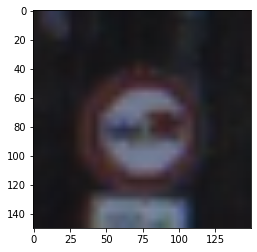

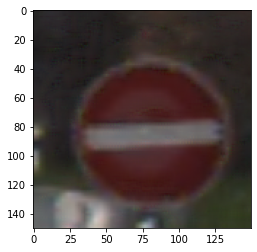

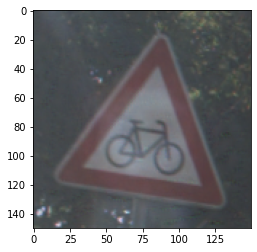

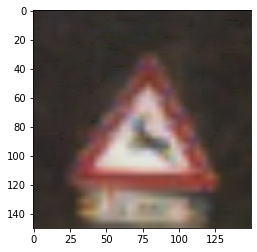

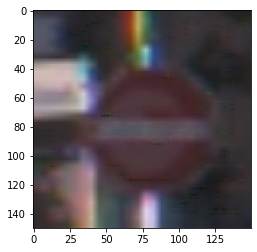

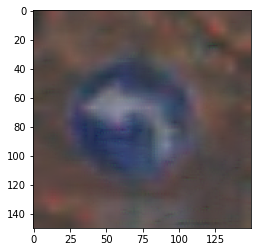

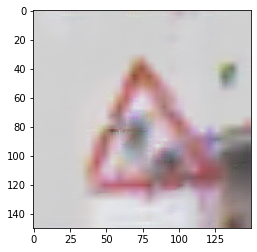

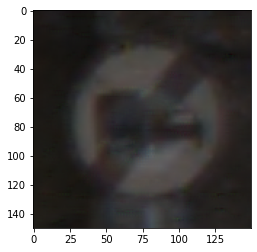

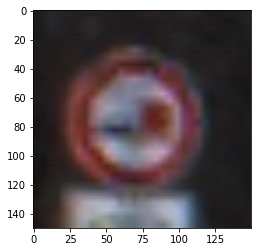

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


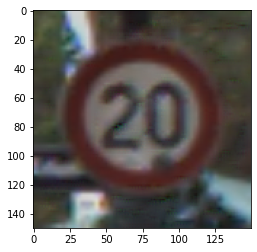

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


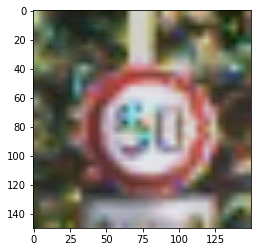

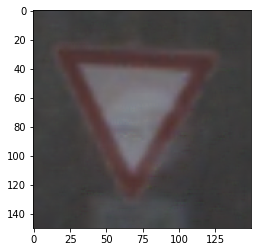

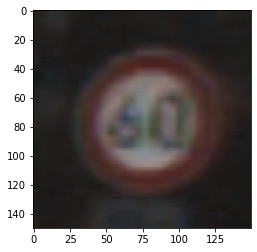

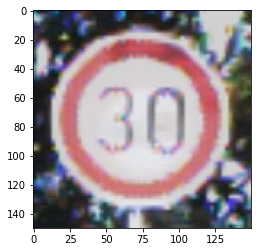

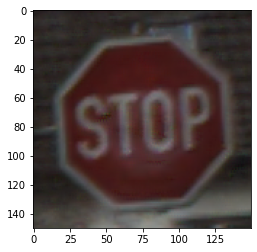

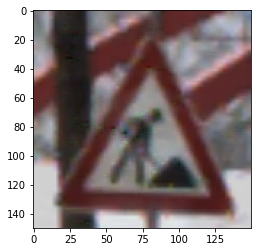

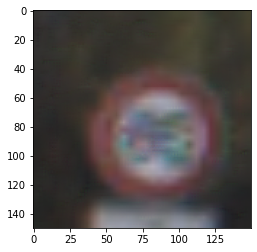

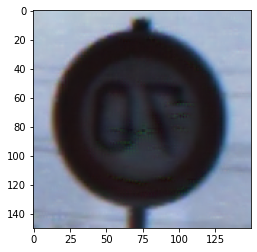

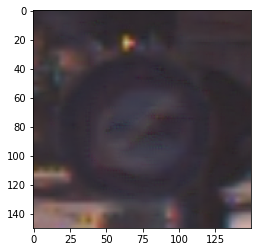

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


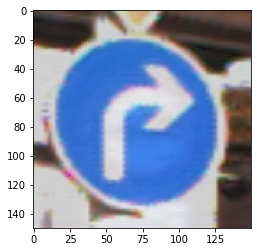

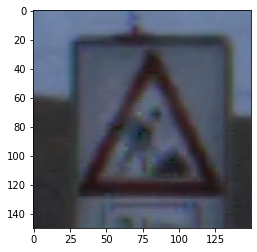

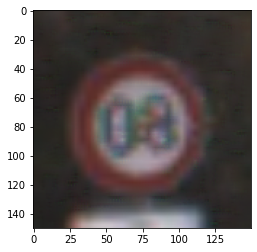

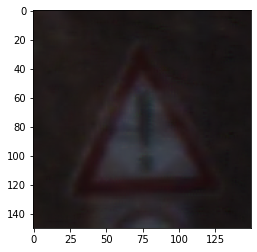

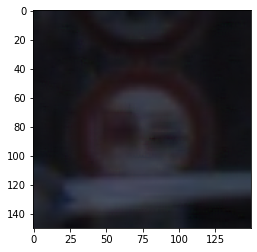

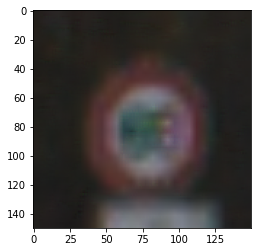

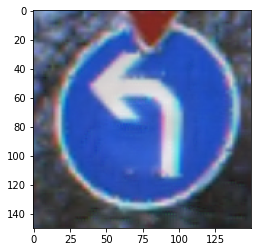

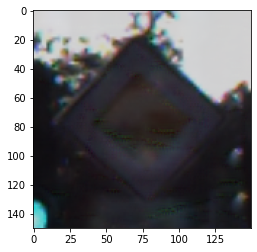

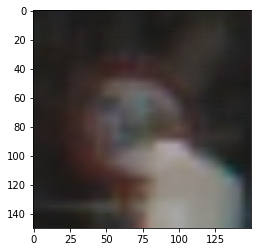

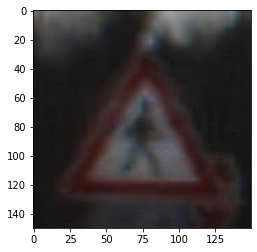

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


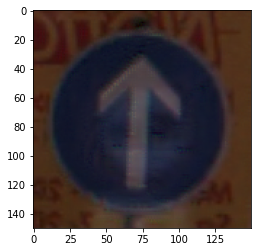

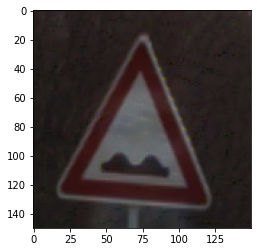

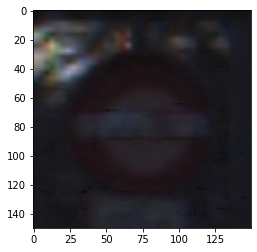

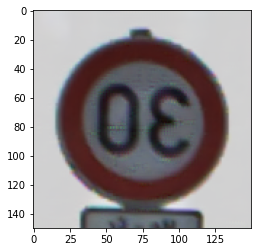

ValueError: ignored

In [ ]:

#End2End training
success_e2e = []
j=0
for test_img in next(iter(test_loader))[0]:
    if next(iter(test_loader))[1][j] == 0:
        imshow(test_img)
        poison_batch = torch.cuda.FloatTensor(n,3,150,150)
        count = 0
        for base_img in next(iter(trainloader_poison))[0]:
            mod = base_img
            for i in range(100):
                mod = forward_e2e(mod,test_img,lr)
                mod = backward(mod,base_img,beta,lr)
            mod = (1-op)*mod + op*(test_img)
            imshow(mod)
            poison_batch[count,:,:,:] = mod
            count+=1
        #Train on poison
        poison_label = next(iter(trainloader_poison))[1]
        train_with_poison_end2end(poison_batch,poison_label)
        #Load model
        cnn = CNN_pre().to(device)
        PATH = "./weights_cnn_poisoned/weights"
        cnn.load_state_dict(torch.load(PATH))
        #Test target instance
        output = F.softmax(cnn(test_img.reshape(-1,3,150,150)),dim=1)
        print(output)
        _, predicted = torch.max(output.data, 1)
        if predicted.item() == 1:
            success_e2e.append(poison_batch)
        print("Target instance is predicted as {}".format(class_name(predicted.item())))
        imshow(test_img)   
    j=j+1
    

In [ ]:
print(len(success_e2e))